# Выделение событий в сигнале

Допустим, вам прислали для сравнения две записи ЭКГ. Специалист, получивший эти записи, работал в MATLAB, где он создал инфраструктуру для манипуляции множества записей. Две из них в формате `struct` он сохранил в формате MATLAB и передал Вам.

In [1]:
%pylab inline
import pandas as pd
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


Функция для загрузки файлов в формате MATLAB есть в пакете `scipy`.

In [2]:
import scipy.io
import scipy.signal

In [3]:
u=r'd/ecg.mat'
o=scipy.io.loadmat(u)
o.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ecg1', 'ecg2'])

Поля, начинающиеся с двойных подчеркиваний, содержат метаданные файла.

In [4]:
o['__header__']

b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Nov 27 19:56:09 2013'

Кроме метаданных в файле две переменные: 'ecg1' и 'ecg2'.

In [5]:
o['ecg1'].dtype

dtype([('data', 'O'), ('name', 'O'), ('name_col', 'O'), ('type', 'O'), ('units', 'O'), ('freq', 'O'), ('source', 'O'), ('date', 'O'), ('begin_time', 'O'), ('version', 'O'), ('data_quality', 'O'), ('history', 'O')])

По-умолчанию, переменная формата `struct` - структура, загружается в формате записи `numpy`: 1 структура - 1 запись.

In [7]:
o['ecg1'].shape

(1, 1)

In [8]:
o['ecg1'].dtype.fields

mappingproxy({'data': (dtype('O'), 0),
              'name': (dtype('O'), 8),
              'name_col': (dtype('O'), 16),
              'type': (dtype('O'), 24),
              'units': (dtype('O'), 32),
              'freq': (dtype('O'), 40),
              'source': (dtype('O'), 48),
              'date': (dtype('O'), 56),
              'begin_time': (dtype('O'), 64),
              'version': (dtype('O'), 72),
              'data_quality': (dtype('O'), 80),
              'history': (dtype('O'), 88)})

Преобразуем структуру в серию pandas.

In [9]:
d = {k:o['ecg1'][0][0][k].squeeze() for k in o['ecg1'].dtype.fields}  #.squeeze() чтобы убрать лишние измерения
d = pd.Series(d)
d

data            [-6669.0, -6743.0, -6810.0, -6729.0, -6636.0, ...
name                                          Электрокардиограмма
name_col                                                      ecg
type                                                            1
units                                                          mV
freq                                                          250
source                                                         []
date                                                  22-Apr-2010
begin_time                                                      0
version                                                      5.16
data_quality                                                    4
history                                 Created by eegdata2oECG 1
dtype: object

Очевидно данные находятся в поле `data`.

(78000,)

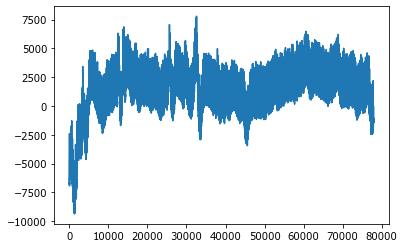

In [10]:
y = (d['data'])
plot(y)
y.shape

Посмотрим фрагмент подробнее.

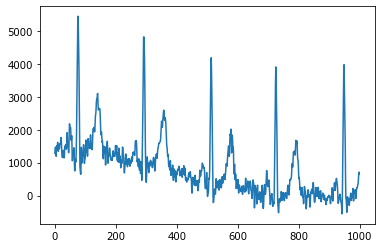

In [11]:
plot(d['data'][17000:18000]);

Да это же кардиограмма! Мы знаем, что сердце бъется примерно один раз в секунду, однако числа по оси Ox не похожи ни на секунды, ни на миллисекунды.

В поле `freq` мы обнаруживаем частоту сигнала.
Частота в Гц - это сколько отсчетов сигнала помещается в 1 с.

In [12]:
freq = float(d['freq'])
freq

250.0

Для второй записи извлечем данные напрямую, поскольку мы уже изучили структуру данных.

In [13]:
y2 = o['ecg2'][0][0]['data']
y2.shape

(150800, 1)

Наложим два сигнала, задавая попарно координаты x и y через запятую.

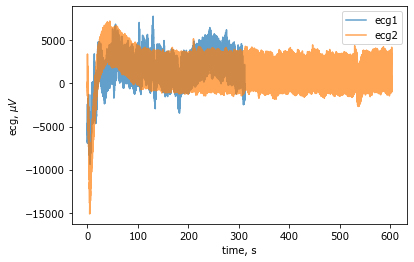

In [14]:
x=arange(0, len(y)/freq, 1/freq)
x2=arange(0, len(y2)/freq, 1/freq)
plot(x,y, x2,y2, alpha=.7)
xlabel('time, s'); ylabel('ecg, $\mu V$'); legend(['ecg1','ecg2']);

Видно, что первая запись продолжалась около 5 мин, а вторая запись длинее - около 10 мин. При этом в начале записи сильно отклоняются от нуля.

Чтобы убрать колебания изолинии - профильтруем сигнал фильтром низких частот.

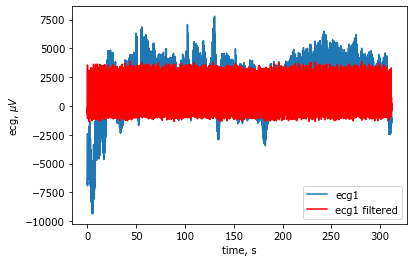

In [15]:
# делаем фильтр с пропусканием выше 2 Гц
b, a = scipy.signal.firwin(int(freq/2), 2/(freq/2), pass_zero=False), 1
# запускаем фильтр без сдвига фазы
yf = scipy.signal.filtfilt(b,a,y)
# смотрим эффект на картинке
plot(x,y, x,yf,'r');
xlabel('time, s'); ylabel('ecg, $\mu V$'); legend(['ecg1','ecg1 filtered']);

Посмотрим поближе на фрагмент записи, чтобы определить надежный порог для поиска R-зубцов.

> Меняйте начальную точку для отображения разных фрагментов.

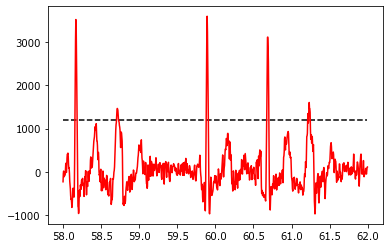

In [16]:
t0 = 58 # начальная точка просмотра, попробуйте поменять
porog=1200  # порог

i0=int(t0*freq)
ii=slice(i0,i0+int(4*freq))
plot(x[ii],yf[ii],'r');

hlines(porog, x[ii][0], x[ii][-1], 'k','--');

Следующий шаг после подбора порогового значения (показан пунктиром на пред. рисунке) - выделить участки выше порога и найти их пиковые значения.

Конечно же существуют специальные пакеты для подсчета пульса по записи ЭКГ с учетом инверсии сигнала, помех и т.д.
Данный алгоритм служит для демонстрации принципов анализа сигналов.

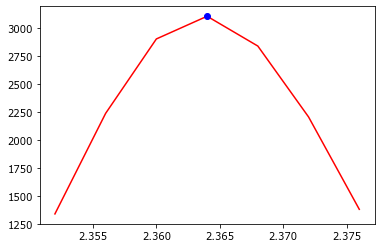

In [17]:
# находим участки сигнала выше порога

#вначале один
i=500
iStart = i + argmax(yf[i:] > porog)   # начало зубца - превышение порога
iEnd = iStart + argmin(yf[iStart:] > porog)  # конец зубца
ii=slice(iStart,iEnd)
plot(x[ii],yf[ii],'r');

iR= iStart + argmax(yf[ii])
plot(x[iR], yf[iR], 'bo');

In [18]:
# теперь повторим это для всех участков
# введем мертвую зону 400 мс, чтобы не попадать на высокие Т-зубцы
nDead=int(0.4*freq)

rr=[]

i=0
while i< len(yf):  # двигаемся вдоль графика
    iStart = i + argmax(yf[i:] > porog)  # начало зубца - превышение порога
    if iStart == i:
        break
    iEnd = iStart + argmin(yf[iStart:] > porog) # конец зубца
    ii=slice(iStart,iEnd)
    iR= iStart + argmax(yf[ii])

    _r=[x[iR], yf[iR]]
    rr.append(_r)
    
    i=iEnd+nDead  #прыгаем через "мертвую зону"

rr.__len__()

376

Найдено 376 сокращений на 300-секундной записи.

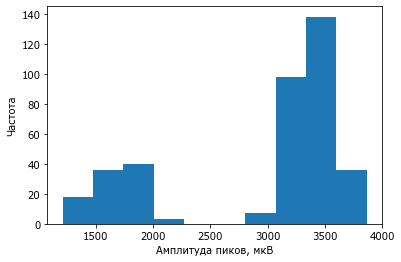

In [19]:
rr = array(rr)
hist(rr[:,1]); xlabel('Амплитуда пиков, мкВ'); ylabel('Частота');

Выделяются два вида зубцов - высокие и низкие (примерно в половину от амплитуды высоких).

Посмотрим как варьируют интервалы между найденными зубцами.

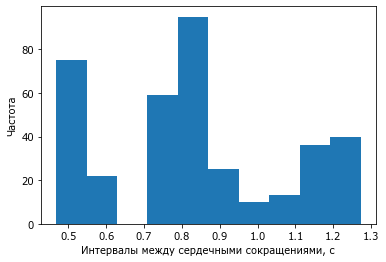

In [20]:
drr=diff(rr[:,0])
hist(drr); xlabel('Интервалы между сердечными сокращениями, с'); ylabel('Частота');

Чаще всего встречались интервалы около 0.8 с (нормальное сердцебиение), также было значительное количество около 0.5 с, и еще одна группа около 1.2 с.

Нарушения ритма могут иметь разные причины. Один из подходов - сопоставить аномальный сердечный цикл с соседними, например, с предыдущим. Для наглядности отложим по горизонтальной оси длительность интервала, а по вертикальной - длительность предыдущего по отношению к нему.

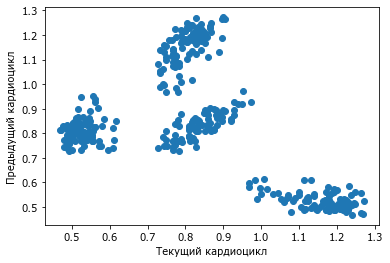

In [23]:
scatter(drr[1:], drr[:-1]);
xlabel('Текущий кардиоцикл'); ylabel('Предыдущий кардиоцикл');

> Если сердце бьётся нормально, то и текущий и предыдущий интервалы равны примерно 0.8 с. Найдите это пересечение. Если человек расслабился, сердечный ритм замедлился, то интервал 0.9 по обеим осям - верхняя правая часть центрального облака. Облако вытянуто наискось, что означает, что частота сокращений изменяется плавно.
Теперь найдем экстрасистолы с интервалом 0.5 с. Перед ними всегда был нормальный интервал около 0.8 с (левое облако точек).
После экстрасистолы всегда возникала пауза (правое нижнее облако).
И осталось последнее верхнее облако - после паузы больше секунды всегда следовало нормальное сокращение.

Мы видим четкие четыре обособленных группы значений! У этого человека серьезные проблемы с сердечной регуляцией. Это пример диагностики без использования статистических методов.
Подробности см. [Экстрасистолия](https://cardio-center.ru/ekstrasistoly.html)

